In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:

# set the seaborn run command for font parameters
sns.set(rc={'font.weight': 'bold'}, font_scale=1.3)

# Load the data
data = pd.read_csv('../data/crime_data_cleaned.csv')

# remove spaces from column names
data.columns = data.columns.str.replace(' ', '')

# format day month year
data['DATEOCC'] = pd.to_datetime(data['DATEOCC'], format='%Y-%m-%d')

print('This dataset shows {} observations and {} features'.format(data.shape[0], data.shape[1]))

This dataset shows 549861 observations and 37 features


### Building a Data Model
We want to build a model that will serve to influence a metric. The metric we are interested in is the clearance rate of crimes. The clearance rate is the percentage of crimes that are "solved" or "cleared" by the police. A crime is considered cleared when an arrest is made, when a suspect is charged, or when the case is closed in some other way. The clearance rate is calculated by dividing the number of crimes that are cleared by the total number of crimes recorded.


### Analyze Crimes Committed - Year over Year

In [3]:
data.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON', 'crime_category',
       'YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY', 'REPORTING_DELAY',
       'crime_type', 'cleared'],
      dtype='object')

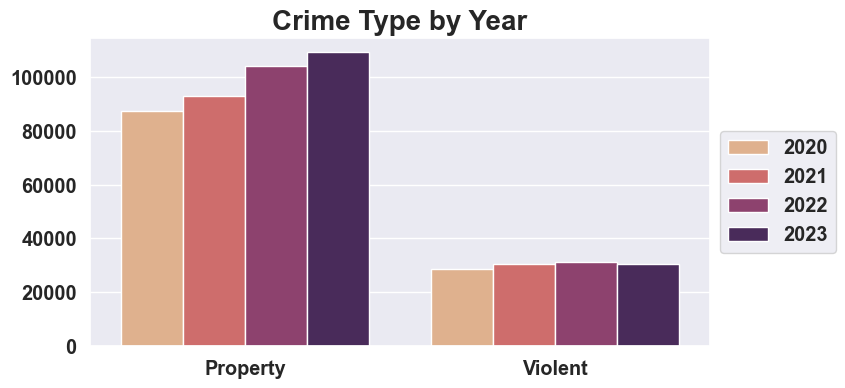

In [4]:
# subset data for plotting
data = data.loc[
                (data['YEAR']!=2024)& # remove 2024 as it's an incomoplete year and will throw off numbers
                (data['crime_type']!='Other') # Other is not relevant for this plot
                ]

# plot crime type by year
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x='crime_type', hue='YEAR', data=data, palette='flare')
plt.title('Crime Type by Year', fontsize=20, fontweight='bold')

# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('')
plt.ylabel('')

plt.show()


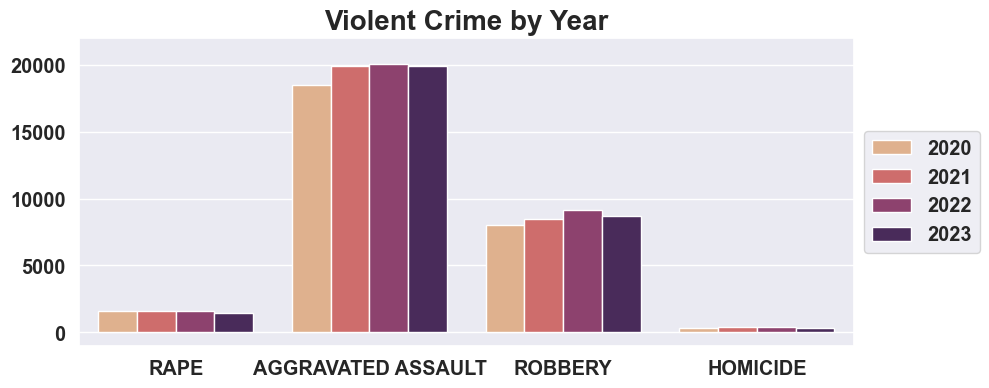

In [5]:
# plot top violent crimes by year
violent_crimes = data[data['crime_type'] == 'Violent']

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='crime_category', hue='YEAR', data=violent_crimes, palette='flare')
plt.title('Violent Crime by Year', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim(-1000,22000)
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [12]:
# plot the difference in year over year violent crimes
yoy_violent_crimes = violent_crimes.pivot_table(index='crime_category', columns='YEAR', values='CrmCdDesc', aggfunc='count').reset_index()

diff = yoy_violent_crimes.iloc[:,1:5].diff(axis=1).iloc[:,1:5]

rate = yoy_violent_crimes.iloc[:,1:5].pct_change(axis=1).iloc[:,1:5].round(2)

# insert crime_category to position 0 axis 1
rate.insert(0, 'crime_category', yoy_violent_crimes['crime_category'])

rate

YEAR,crime_category,2021,2022,2023
0,AGGRAVATED ASSAULT,0.08,0.01,-0.01
1,HOMICIDE,0.14,-0.02,-0.16
2,RAPE,0.03,-0.02,-0.12
3,ROBBERY,0.06,0.07,-0.05


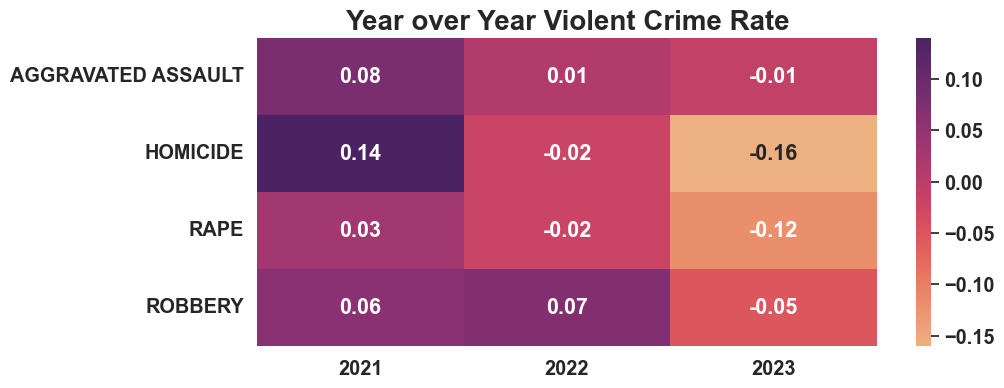

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rate.set_index('crime_category'), annot=True, cmap='flare', fmt='g')
plt.title('Year over Year Violent Crime Rate', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()


In [ ]:
# property crime by year
property_crimes = data[data['crime_type'] == 'Property']

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='crime_category', hue='YEAR', data=property_crimes, palette='flare')
plt.title('Property Crime by Year', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim(-1000,50000)
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
# plot the difference in year over year property crimes
yoy_property_crimes = property_crimes.pivot_table(index='crime_category', columns='YEAR', values='CrmCdDesc', aggfunc='count')

diff = yoy_property_crimes.pct_change(axis=1).dropna(axis=1).round(2)

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(diff, annot=True, fmt=".0%", cmap='flare')
plt.title('Year over Year Change in Property Crime', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
# show legend

plt.show()


### Now lets look at the crime clearance rates


### Plot the Data

### Analyze the Year over Year Clearance Rate of Crimes

In [ ]:
cleared = data.pivot_table(index='crime_category', columns='YEAR', values='cleared', aggfunc='sum', fill_value=0).reset_index()

cleared

In [ ]:
# calculate year over year difference
diff = cleared.iloc[:,1:5].diff(axis=1).iloc[:,1:5]

# calculate the rate of change
rate = (diff.div(cleared.iloc[:,1:4].iloc[:,0:3].values) * 100).round(2)

# add AREANAME column back to rate dataframe
rate.insert(0, 'AREANAME', cleared['crime_category'])

rate

In [ ]:

# create a heatmap of the rate of change
plt.figure(figsize=(12,6))
sns.heatmap(rate.set_index('AREANAME'), annot=True, fmt='.2f', cmap='Blues')
plt.title('Rate of Change in Cleared Crimes', fontsize=20, fontweight='bold', color='black')
plt.ylabel('Crime Category', labelpad=20)
plt.xlabel('Year', labelpad=20)
plt.show()


### Let's Look at Each of the Serious Crimes Individually

In [ ]:
# create a dataframe for criminal homicide 
homicide = data.query('crime_category == "HOMICIDE"')

In [ ]:
homicide.columns

In [ ]:
# build the model islolating appropriate columns
homicide = homicide.loc[:,['DateRptd', 'DATEOCC', 'TIMEOCC','AREANAME','CrmCdDesc','VictAge','VictSex', 'VictDescent','PremisDesc','WeaponDesc', 'Status','StatusDesc','crime_category','YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY', 'REPORTING_DELAY','cleared']]

homicide[:1]

In [ ]:
# fill the nulls in WeaponDesc with ''
homicide['WeaponDesc'] = homicide['WeaponDesc'].fillna('')

### We will use NLP to vectorize the words and run a logistic regression model to look at words that lead to arrest
We will look at the following columns:
`PremisDesc` and `WeaponDesc` to see if we can extract any words that can predict the arrest of a crime.
<br>
Here are the steps involved:
1.  Create training and testing data
2.  Vectorize the words
3.  Run a logistic regression model
4.  Look at the words that lead to arrest


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['WeaponDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

In [ ]:
# display max rows
pd.set_option('display.max_rows', None)

list(X_train.values)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['WeaponDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['WeaponDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


### Scale The Data

In [ ]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

### Fit the model

In [ ]:
# build the model
from sklearn.linear_model import LogisticRegression

# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [ ]:

# evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


In [ ]:

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


In [ ]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

In [ ]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)
plt.xticks(rotation=45);

In [ ]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
plt.xticks(rotation=45);


### Let's apply the same rigor to PremisDesc

In [ ]:
# resolve the nulls
homicide['PremisDesc'] = homicide['PremisDesc'].fillna('')

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['PremisDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

### Vectorize the words

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['PremisDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['PremisDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


### Scale the data

In [ ]:
scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

### Fit the model

In [ ]:
# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


### Evaluate the coefficients

In [ ]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

In [ ]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)
# align x-axis labels for readability
plt.xticks(rotation=45, ha='right');

In [ ]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
# align the labels 
plt.xticks(rotation=45, ha='right');
    


### Finalize the data model

In [ ]:
display(homicide.columns)
display(homicide[:3])

In [ ]:
drop_cols = ['DateRptd','DATEOCC','TIMEOCC','CrmCdDesc','Status','StatusDesc','crime_category']

homicide.drop(drop_cols, axis=1, inplace=True)

homicide.columns

In [ ]:
homicide[:5]

### Model is ready for machine learning


In [ ]:
# imputation strategy

# for missing VictSex, fill with 'U' for unknown
homicide['VictSex'] = homicide['VictSex'].fillna('')

# for missing VictDescent, fill with 'U' for unknown
homicide['VictDescent'] = homicide['VictDescent'].fillna('')

# for missing Time_of_day, fill with missing
homicide['TIME_OF_DAY'] = homicide['TIME_OF_DAY'].fillna('')


In [ ]:
homicide.to_csv('../data/homicide.csv', index=False)
print('Homicide data model successfully saved.')